In [174]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from models.BRUTAL_radially_constrained_cluster import *  # Adjust import as per your package structure

In [175]:
n_seas = 2
iters = 100

In [176]:
dataset_t2m = xr.open_mfdataset(rf'../data/preprocessed/ERA5/2m_temperature/final.nc')['2t'].load().sel(lat=30, lon=75, method='nearest')
dataset_tp = xr.open_mfdataset(rf'../data/preprocessed/ERA5/total_precipitation/final.nc').tp.load().sel(lat=30, lon=75, method='nearest')
dataset_u100 = xr.open_mfdataset(rf'../data/preprocessed/ERA5/100m_u_wind/final.nc').u100.load().sel(lat=30, lon=75, method='nearest')
dataset_v100 = xr.open_mfdataset(rf'../data/preprocessed/ERA5/100m_v_wind/final.nc').v100.load().sel(lat=30, lon=75, method='nearest')

dataset_tp['time'] = dataset_t2m['time']
dataset_u100['time'] = dataset_t2m['time']
dataset_v100['time'] = dataset_t2m['time']

datasets = [dataset_tp, dataset_t2m]  # Add as many datasets as needed

In [177]:
arrays = []

for grid_points_var in datasets:
    grid_points_var = np.asarray(grid_points_var)
    grid_points_var = np.reshape(grid_points_var, (365, int(grid_points_var.size/365)), order='F')
    
    if np.isnan(grid_points_var).any():
        array_tot = (np.full(n_seas, np.nan), np.full(iters, np.nan), np.full(iters, np.nan))
    
    arrays.append(grid_points_var)

combined_mask = ~np.any([np.all(np.isnan(arr), axis=0) for arr in arrays], axis=0)

normalized_arrays = []
for arr in arrays:
    array_tot = arr[:, combined_mask]
    array_tot = (array_tot - array_tot.min(axis=1).reshape(-1, 1)) / (array_tot.max(axis=1) - array_tot.min(axis=1)).reshape(-1, 1)
    #array_tot = (array_tot - array_tot.mean(axis=1).reshape(-1, 1)) / array_tot.std(axis=1).reshape(-1, 1)
    normalized_arrays.append(array_tot)

    array_tot = np.concatenate(normalized_arrays, axis=1)

In [178]:
array_tot.shape

(365, 100)

In [179]:
b = [20, 50]

def generate_season_idx(b):

        idx = []

        if n_seas == 1:
            idx.append(np.arange(0, 365, 1))

        else:
            for i in np.arange(-1, n_seas-1,1):
                if b[i]>b[i+1]:
                    idx_0 = np.arange(b[i], 365, 1)
                    idx_1 = np.arange(0, b[i+1], 1)
                    idx.append(np.concatenate((idx_0, idx_1), axis=None))

                else:
                    idx.append(np.arange(b[i], b[i+1],1))

        return idx



def compute_metrics(n_season, data_to_cluster, idx):

    centroids = []
    error = []

    for i in range(n_season):
                
        centroids.append(np.nanmean(data_to_cluster[idx[i]]))
        error.append(np.nansum(np.power(data_to_cluster[idx[i]]-centroids[i],2)))
        #error.append(np.nansum(np.power(data_to_cluster[idx[i]]-data_to_cluster[idx[i]],2), axis = 0))

    return centroids, error


In [180]:
generate_season_idx(b)

[array([ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
         63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
         76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
         89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
        102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
        115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
        128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
        141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
        167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
        180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192,
        193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218,
        219, 220, 221, 222, 223, 224, 225, 226, 227

In [181]:
centroids, error = compute_metrics(n_seas, array_tot, generate_season_idx(b))

In [182]:
# a = array_tot[idx[1]].flatten()[0::50]
# # Definiamo una versione vettorializzata di pscore
# vectorized_pscore = np.vectorize(lambda x: pscore(a, x).compute()[0])

# # Calcoliamo l'errore per ogni elemento
# err = vectorized_pscore(a)

In [183]:
# def compute_metrics(n_season, data_to_cluster, idx):

#     centroids = []
#     error = []

#     for i in range(n_season):
                
#         centroids.append(np.nanmean(data_to_cluster[idx[i]]))
#         error.append(np.nansum(np.power(data_to_cluster[idx[i]]-centroids[i],2)))

#     return centroids, error

In [184]:
import numpy as np
from scipy.spatial.distance import mahalanobis
from scipy.spatial.distance import cosine
from scipy.spatial.distance import hamming
from scipy.spatial.distance import jaccard

def compute_metrics(n_season, data_to_cluster, idx, metric='euclidean', p=2, covariance_matrix=None):
    """
    Calcola i centroidi e l'errore per ciascun cluster utilizzando diverse metriche.

    Parameters:
    n_season (int): Numero di cluster.
    data_to_cluster (array): Array di dati da clusterizzare.
    idx (list of arrays): Lista di indici per ciascun cluster.
    metric (str): La metrica da utilizzare per il calcolo dell'errore.
                  Opzioni: 'euclidean', 'manhattan', 'chebyshev', 'minkowski', 
                           'cosine', 'hamming', 'jaccard', 'mahalanobis'
    p (int): Parametro per la distanza di Minkowski (solo se metric='minkowski').
    covariance_matrix (array): Matrice di covarianza per la distanza di Mahalanobis.

    Returns:
    centroids (list): Lista dei centroidi per ciascun cluster.
    error (list): Lista degli errori per ciascun cluster secondo la metrica scelta.
    """
    centroids = []
    error = []

    for i in range(n_season):
        # Otteniamo i dati del cluster corrente
        data_cluster = data_to_cluster[idx[i]]

        # Calcolo del centroide (media ignorando i NaN)
        centroid = np.nanmean(data_cluster, axis=0)
        centroids.append(centroid)
        
        # Calcoliamo l'errore in base alla metrica scelta
        if metric == 'euclidean':
            # Distanza Euclidea
            error.append(np.nansum(np.power(data_cluster - centroid, 2)))

        elif metric == 'manhattan':
            # Distanza di Manhattan (L1)
            error.append(np.nansum(np.abs(data_cluster - centroid)))

        elif metric == 'chebyshev':
            # Distanza di Chebyshev (massima distanza su un asse)
            error.append(np.nanmax(np.abs(data_cluster - centroid)))

        elif metric == 'minkowski':
            # Distanza di Minkowski (generale)
            error.append(np.nansum(np.power(np.abs(data_cluster - centroid), p))**(1/p))

        elif metric == 'cosine':
            # Distanza Coseno (usando il vettore medio come centroide)
            error.append(np.nansum([cosine(row, centroid) for row in data_cluster]))

        elif metric == 'hamming':
            # Distanza di Hamming (per dati categoriali o binari)
            error.append(np.nansum([hamming(row, centroid) for row in data_cluster]))

        elif metric == 'jaccard':
            # Distanza di Jaccard (per vettori binari)
            error.append(np.nansum([jaccard(row, centroid) for row in data_cluster]))

        elif metric == 'mahalanobis':
            # Distanza di Mahalanobis (richiede una matrice di covarianza)
            if covariance_matrix is None:
                raise ValueError("Per la distanza di Mahalanobis è necessaria una matrice di covarianza.")
            inv_covmat = np.linalg.inv(covariance_matrix)
            error.append(np.nansum([mahalanobis(row, centroid, inv_covmat) for row in data_cluster]))

        else:
            raise ValueError(f"Metrica non riconosciuta: {metric}")

    return centroids, error




In [185]:
from itertools import combinations

n_days = list(np.arange(0,365,1))

err = []
# Genera tutte le combinazioni possibili di 4 date su 100 giorni
for combination in tqdm(combinations(n_days, 2)):
    b = list(combination)

    centroids, error = compute_metrics(n_seas, array_tot, generate_season_idx(b))

    err.append(np.nanmean(error))

66430it [00:51, 1297.73it/s]


In [186]:
centroids

[array([0.1406895 , 0.19750635, 0.1692018 , 0.2531653 , 0.20479903,
        0.09907345, 0.1810418 , 0.2799796 , 0.20145041, 0.14204533,
        0.2099274 , 0.21900657, 0.22744855, 0.2664676 , 0.3269205 ,
        0.13123232, 0.17607917, 0.15433133, 0.13641281, 0.1890131 ,
        0.161497  , 0.20960292, 0.1957814 , 0.18812093, 0.1299118 ,
        0.19396359, 0.23075798, 0.22153698, 0.3240168 , 0.23780091,
        0.15905684, 0.12632221, 0.17951992, 0.10077477, 0.1601997 ,
        0.17432137, 0.19774844, 0.15772378, 0.19105846, 0.21793953,
        0.12045249, 0.17831077, 0.22189645, 0.16512549, 0.23771296,
        0.1756914 , 0.26901457, 0.14547583, 0.17681025, 0.16583343,
        0.6109952 , 0.53945786, 0.5197137 , 0.49498057, 0.5056388 ,
        0.5266908 , 0.4150081 , 0.38079605, 0.3968471 , 0.38498294,
        0.47701508, 0.5263059 , 0.5129562 , 0.40368333, 0.30125797,
        0.48033577, 0.50052214, 0.4196839 , 0.6003633 , 0.5176953 ,
        0.40471783, 0.49058986, 0.5084117 , 0.40

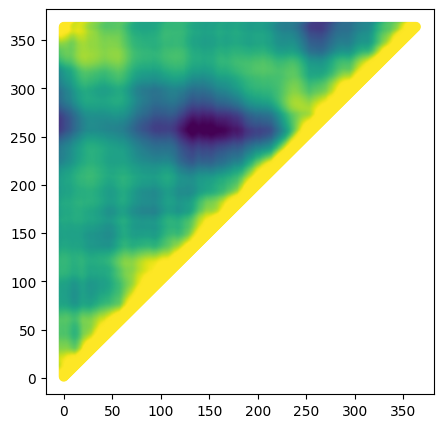

In [192]:
x = np.array(list(combinations(n_days, 2))).squeeze()[:,0]
y = np.array(list(combinations(n_days, 2))).squeeze()[:,1]

fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.scatter(x, y, c=err, cmap='viridis', vmin=850, vmax=920)

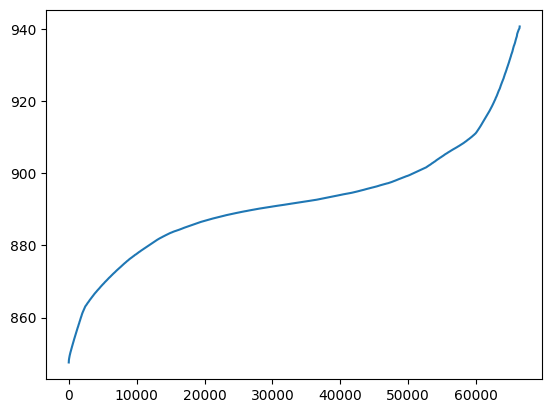

In [189]:
plt.plot(np.sort(err))